#Training 

##Import Modules 

In [1]:
import numpy
import cv2
import scipy.linalg
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from random import randint
import torch.nn.functional as F 
import random
from google.colab import drive
from scipy.linalg import sqrtm 
drive.mount('/content/drive')

Mounted at /content/drive


##Loading Unordered data frame 

In [2]:
df = pd.read_csv('/content/drive/MyDrive/intelligent_font_files/CSV_files/mygdatasheet12.csv')
df.drop(df.columns[[0]], axis = 1, inplace = True)
print(df)

      previous alphabet current alphabet next alphabet  \
0                     e                c             t   
1                     h                e             n   
2                                      y             o   
3                     w                e             a   
4                                      t             h   
...                 ...              ...           ...   
12547                 f                o             r   
12548                 w                o             u   
12549                 w                h             o   
12550                                  d             a   
12551                                  p             r   

                                     spacial information  \
0                     [[21, 35], [1200.875, 569.390625]]   
1      [[16, 11], [932.171052631579, 236.3421052631579]]   
2      [[7, 23], [439.9656862745098, 432.3480392156863]]   
3      [[21, 37], [1199.2894736842106, 622.1315789473...   
4  

##HyperParameters 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
IMG_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES = 27
GEN_EMBEDDING = 100 

Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

##Discriminator 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size 
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+5, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding (num_classes, img_size*img_size).to(device)
    

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding0 = self.embed(torch.Tensor([labels[0]]).type(torch.cuda.LongTensor).to(device)).view(1, 1, self.img_size, self.img_size)
        embedding1 = self.embed(torch.Tensor([labels[1]]).type(torch.cuda.LongTensor).to(device)).view(1, 1, self.img_size, self.img_size)
        embedding2 = self.embed(torch.Tensor([labels[2]]).type(torch.cuda.LongTensor).to(device)).view(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding0,embedding1,embedding1,embedding1, embedding2 ], dim = 1)
        return self.disc(x)

##Generator 

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size 
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+ embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed1 = nn.Embedding(num_classes, 60).to(device)
        self.embed0 = nn.Embedding(num_classes, 20).to(device)
        self.embed2 = nn.Embedding(num_classes, 20).to(device)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding0 = self.embed0(torch.Tensor([labels[0]]).type(torch.cuda.LongTensor).to(device)).unsqueeze(2).unsqueeze(3)
        embedding1 = self.embed1(torch.Tensor([labels[1]]).type(torch.cuda.LongTensor).to(device)).unsqueeze(2).unsqueeze(3)
        embedding2 = self.embed2(torch.Tensor([labels[2]]).type(torch.cuda.LongTensor).to(device)).unsqueeze(2).unsqueeze(3)
        # print(x.size())
        # print(embedding0.size())
        # print(embedding1.size())
        # print(embedding2.size())
        x = torch.cat([x, embedding0, embedding1, embedding2], dim = 1)
        return self.net(x)

##Initialize weights 

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

##Gradient Panality

In [ ]:
def gradient_penalty(critic,labels,  real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

##Initialization

In [ ]:
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()


Discriminator(
  (disc): Sequential(
    (0): Conv2d(6, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(27, 4096

##UtilityFunctions 

In [7]:
NOISE_DIM = Z_DIM

def normalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        # myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
        myarr[i][j] =  ((myarr[i][j] *2)/255) -1 
  return myarr



def denormalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
  return myarr


def gettensorinput(arr): 
        arr1 = arr
        arr1 = normalize(arr)
        real = torch.tensor(arr1).to(device)
        real =torch.unsqueeze(real, 0)
        real = torch.unsqueeze(real, 0)   
        real = real.type(torch.cuda.FloatTensor)
        return real


def getlabel(n): 
        number = ord(df.iloc[n][1]) -97
        a_list = [number]
        a_tensor = torch.Tensor(a_list)
        a_tensor.to(device)
        labels = a_tensor.type(torch.cuda.LongTensor)
        return labels 

def getnumpyout(tensor): 
  res = torch.squeeze(tensor, 0)
  res1 = torch.squeeze(res, 0)
  resnp = res1.cpu().detach().numpy()
  resfi = denormalize(resnp)
  return resfi


def getlabel1(n): 
        number = n -97
        a_list = [number]
        a_tensor = torch.Tensor(a_list)
        a_tensor.to(device)
        labels = a_tensor.type(torch.cuda.LongTensor)
        return labels 


def getlabel_adv(n): 

        if ord(df.iloc[n][0]) != 32: 
          number1 = ord(df.iloc[n][0]) -97
        else: 
          number1 = 26 
        if ord(df.iloc[n][1]) != 32: 
          number2 = ord(df.iloc[n][1]) -97
        else: 
          number2 = 26 
        if ord(df.iloc[n][2]) != 32: 
          number3 = ord(df.iloc[n][2]) -97
        else: 
          number3 = 26 
        labels = [number1, number2, number3]
        return labels 

def noisetensor(a,b,c):
    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    for i in range(NOISE_DIM): 
      if i < 0.2 * NOISE_DIM: 
        noise[0][i][0][0] = a
      if i < 0.8 * NOISE_DIM and i>= 0.2*NOISE_DIM: 
        noise[0][i][0][0] = b
      if i < NOISE_DIM and i >= 0.8 * NOISE_DIM : 
        noise[0][i][0][0] = c
    return noise


def noisetensorbasic(b):
    noise = torch.randn(1, 100, 1, 1).to(device)
    for i in range(Z_DIM):
      noise[0][i][0][0] = b-97
    return noise


##Training 

epoch is : 0 iteration is 0
original handwritten character


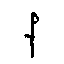

Artificial intelligence replicating my character


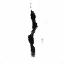

---------------------------------------------------------
epoch is : 0 iteration is 1000
original handwritten character


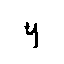

Artificial intelligence replicating my character


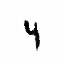

---------------------------------------------------------
epoch is : 0 iteration is 2000
original handwritten character


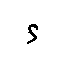

Artificial intelligence replicating my character


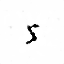

---------------------------------------------------------
epoch is : 0 iteration is 3000
original handwritten character


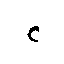

Artificial intelligence replicating my character


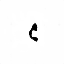

---------------------------------------------------------
epoch is : 0 iteration is 4000
original handwritten character


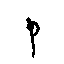

Artificial intelligence replicating my character


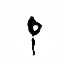

---------------------------------------------------------
epoch is : 0 iteration is 5000
original handwritten character


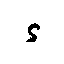

Artificial intelligence replicating my character


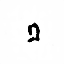

---------------------------------------------------------
epoch is : 0 iteration is 6000
original handwritten character


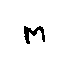

Artificial intelligence replicating my character


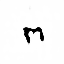

---------------------------------------------------------
epoch is : 0 iteration is 7000
original handwritten character


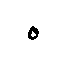

Artificial intelligence replicating my character


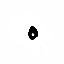

---------------------------------------------------------
epoch is : 0 iteration is 8000
original handwritten character


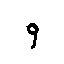

Artificial intelligence replicating my character


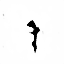

---------------------------------------------------------
epoch is : 0 iteration is 9000
original handwritten character


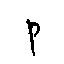

Artificial intelligence replicating my character


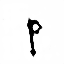

---------------------------------------------------------
epoch is : 0 iteration is 10000
original handwritten character


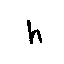

Artificial intelligence replicating my character


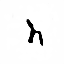

---------------------------------------------------------
epoch is : 0 iteration is 11000
original handwritten character


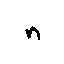

Artificial intelligence replicating my character


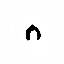

---------------------------------------------------------
epoch is : 0 iteration is 12000
original handwritten character


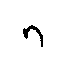

Artificial intelligence replicating my character


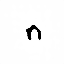

---------------------------------------------------------


In [ ]:
for epoch in range(1):
    state = {
    'gen': gen.state_dict(),
    'critic': critic.state_dict(),
    'opt_gen': opt_gen.state_dict(),
    'opt_critic': opt_critic.state_dict(),
        }
    # file_name = '/content/drive/MyDrive/all_trained_models/icdcgan/icdcgan_epoch' + str(epoch) + '.pth.tar'
    # torch.save(state, file_name)
    for i in range(len(df)):
        real = gettensorinput(eval(df.iloc[i][4]))
        labels = getlabel_adv(i)

        for _ in range(CRITIC_ITERATIONS):
            # noise = noisetensorbasic(ord(df.iloc[i][1])).to(device)
            noise = torch.randn(1, Z_DIM, 1, 1).to(device)
            fake = gen(noise,labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic,labels,  real, fake, device=device)
            loss_critic = (     
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    
        if i%1000 == 0:
          print('epoch is : ' + str(epoch) + ' iteration is '+ str(i))
          
          lis = eval(df.iloc[i][4])
          nparr = numpy.asarray(lis)
          print('original handwritten character')
          cv2_imshow(nparr)  



          labels = getlabel_adv(i)
          res = gen(noise, labels)
          resnp = getnumpyout(res)
          print('Artificial intelligence replicating my character')
          cv2_imshow(resnp)  
          print('---------------------------------------------------------')




#DEMO

##Loading Ordered Data Frame 

In [8]:
df = pd.read_csv('/content/drive/MyDrive/intelligent_font_files/CSV_files/mygdatasheet12_ordered_data.csv')
df.drop(df.columns[[0]], axis = 1, inplace = True)
print(df)

      previous alphabet current alphabet next alphabet  \
0                                      f             o   
1                     f                o             l   
2                     o                l             l   
3                     l                l             o   
4                     l                o             w   
...                 ...              ...           ...   
12001                                  f             u   
12002                 f                u             t   
12003                 u                t             r   
12004                 t                r             e   
12005                 r                e                 

                                     spacial information  \
0                    [[0, 0], [39.14141414141414, 67.0]]   
1       [[0, 1], [44.83673469387755, 84.26530612244898]]   
2      [[0, 2], [40.78666666666667, 100.57333333333334]]   
3      [[0, 3], [44.61971830985915, 110.21126760563381]]   
4  

## Loading Trained Models 

In [9]:
state = torch.load('/content/drive/MyDrive/intelligent_font_files/all_trained_models/icdcgan/icdcgan_epoch20.pth.tar')


model =  Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING)
model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
model.to(device)


model1 = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE)
model1.load_state_dict(state['critic'])  # Choose whatever GPU device number you want
model1.to(device)

opt_gen1 = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_gen1.load_state_dict(state['opt_gen'])
opt_critic1.load_state_dict(state['opt_critic'])


##Character Generation 

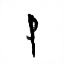

[[244.69674682617188,
  254.5697021484375,
  254.9390869140625,
  254.97640991210938,
  254.96340942382812,
  254.97036743164062,
  254.97491455078125,
  254.97328186035156,
  254.91542053222656,
  254.90248107910156,
  254.90260314941406,
  254.92410278320312,
  254.8940887451172,
  254.9342498779297,
  254.95742797851562,
  254.96829223632812,
  254.9395751953125,
  254.95236206054688,
  254.9666748046875,
  254.97525024414062,
  254.9603729248047,
  254.9709014892578,
  254.98046875,
  254.98342895507812,
  254.9685516357422,
  254.97605895996094,
  254.98426818847656,
  254.98683166503906,
  254.9767303466797,
  254.98170471191406,
  254.98614501953125,
  254.98585510253906,
  254.960205078125,
  254.95968627929688,
  254.96641540527344,
  254.97242736816406,
  254.95018005371094,
  254.96044921875,
  254.9699249267578,
  254.9744110107422,
  254.9497528076172,
  254.9668426513672,
  254.9827880859375,
  254.98867797851562,
  254.98495483398438,
  254.99075317382812,
  254.99452209

In [10]:
def demo(model, labels): 
  noise = torch.randn(1, Z_DIM, 1, 1).to(device)
  res = model(noise, labels)
  resnp = getnumpyout(res)
  cv2_imshow(resnp) 
  resnp = resnp.tolist()
  return resnp

demo(model, [26, 5, 14])



##Utility Files 

In [11]:
from torch._C import NoneType
from statistics import mean

def getdisplacement (df, charac1, charac2): 
  print(type(charac1))
  instances = 0
  rowdifflist = [0]
  rowdifflist2 = [0]
  coldifflist = [13]
  for i in range(len(df)):
    if df.iloc[i][0] == charac1 and df.iloc[i][1] == charac2  : 
      listt1 = eval(df.iloc[i-1][3])
      listt2 = eval(df.iloc[i][3])
      if listt1[0][0] == listt2[0][0]:
        instances = instances +1
        coldifflist.append(listt2[1][1] - listt1[1][1])
        rowdifflist2.append(listt2[1][0]- listt1[1][0])
  return [mean(rowdifflist2), mean(coldifflist), instances]

print(getdisplacement(df, 'f', 'o'))

def getset(res, m, n): 
  sett = set()
  for i in range(64): 
    for j in range(64): 
      if res[i][j] < 150: 
        sett.add((i+m,j+n))
  return sett

def listoflist (string): 
  mainlis = []
  lis = []
  lis.append(26)
  for i in range(len(string)):
    if string[i] == ' ': 
      lis.append(26)
    else: 
      lis.append(ord(string[i])- 97)
  lis.append(26)
  for i in range(1, len(lis)-1): 
    mainlis.append([lis[i-1], lis[i], lis[i+1]])
  return mainlis 



<class 'str'>
[5.454425069859305, 14.694619990386228, 48]


##Final Demo

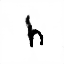

<class 'str'>


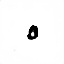

<class 'str'>


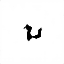

<class 'str'>


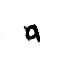

<class 'str'>


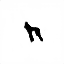

<class 'str'>


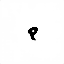

<class 'str'>


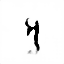

<class 'str'>


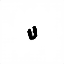

<class 'str'>


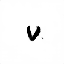

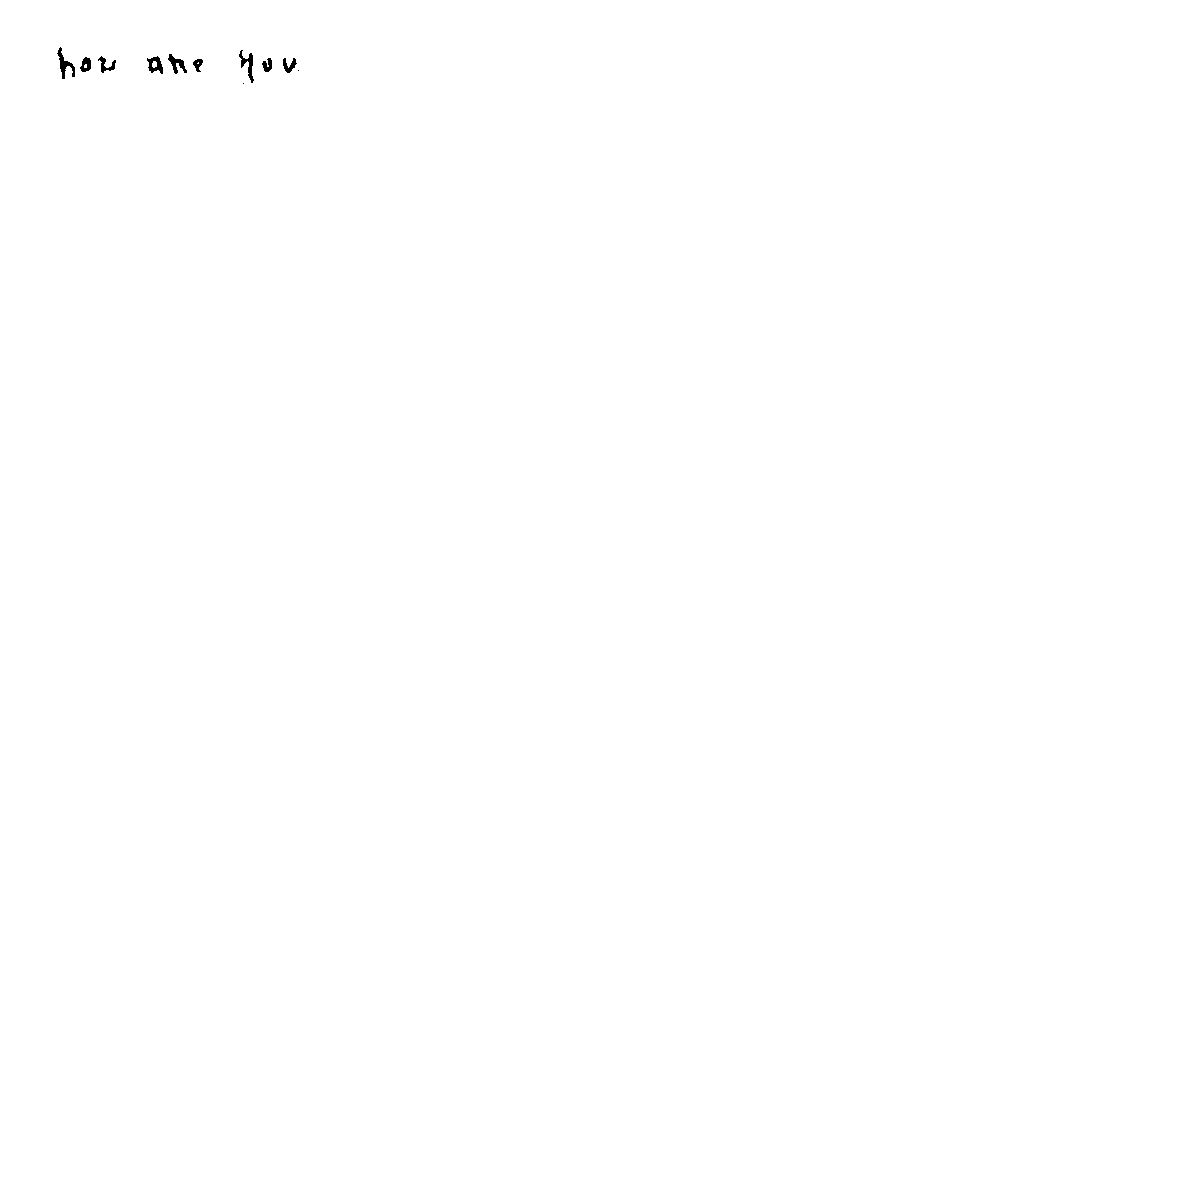

In [13]:
def ShowMeTheDemo(df, model, string, row, col):
  string = listoflist (string) 
  whole = [[255 for i in range(row)] for j in range(col)]
  n = len(string)
  cur_center = [32, 32]
  current_displacement = [0, 0]
  res =   demo(model, string[0])
  sett = getset(res, cur_center[0], cur_center[1])

  for x, y in sett:
    if int(x) in range(640) and int(y) in range(640): 
      whole[int(x)][int(y)] = 0

  displacement = [0, 15] 

  
  for i in range(1, n): 
    if string[i][1] == 26: 
      cur_center[1] = cur_center[1] + displacement[1] + 15
      continue 
    
    if cur_center[1]> 1150: 
      cur_center[0] =   cur_center[0] + 64
      cur_center[1] = 32

    if string[i][0] != 26:
      displacement = getdisplacement (df, chr(string[i][0]), chr(string[i][1]))
    else: 
      displacement = getdisplacement (df, ' ', chr(string[i][1]))

    cur_center[0] = cur_center[0] + displacement[0]
    cur_center[1] = cur_center[1] + displacement[1] + 8
    res =   demo(model, string[i])
    sett = getset(res, cur_center[0], cur_center[1])

    for x, y in sett:
      if int(x) in range(row) and int(y) in range(col): 
        whole[int(x)][int(y)] = 0
  whole = numpy.array(whole)
  cv2_imshow(whole) 

#Enter Your String Here 

string = 'how are you'

ShowMeTheDemo(df, model,  string, 1200, 1200) 

#FID Calculations

##FID Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(4096, 26)
        # self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        y = x.reshape(x.shape[0], -1)
        x = self.fc1(y)
        return x, y

##Loading Trained FID Model 

In [ ]:
model_fid = CNN(in_channels=1, num_classes=26).to(device)
model_fid = torch.load('/content/drive/MyDrive/intelligent_font_files/all_trained_models/fid/fid_epoch3.pth.tar')
model_fid.eval()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=26, bias=True)
)

##Utility Functions 

In [ ]:
def accuracy(df, model): 
  count = 0
  for i in range(len(df)): 
    scores, _ = model(gettensorinput(eval(df.iloc[i][4])))
    scores = scores.squeeze(dim = 0)
    scores = scores.tolist()
    index = scores.index(max(scores))
    if index == (ord(df.iloc[i][1]) - 97): 
      # print('here')
      count = count + 1
    
  print('accuracy is : ' + str(count/len(df)))

  return count/len(df)

def gettensorinput(arr): 
        arr1 = arr
        arr1 = normalize(arr)
        real = torch.tensor(arr1).to(device)
        real =torch.unsqueeze(real, 0)
        real = torch.unsqueeze(real, 0)   
        real = real.type(torch.cuda.FloatTensor)
        return real

def normalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        # myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
        myarr[i][j] =  ((myarr[i][j] *2)/255) -1 
  return myarr


##Accuracy of Loaded FID Model 

In [ ]:
print(accuracy(df[10000:], model_fid))

accuracy is : 0.9935194416749751
0.9935194416749751


##Utility Functions 

In [ ]:
from scipy.linalg import sqrtm 
def fid_score_calculator(d1, d2): 
  d1 = d1.type(torch.float)
  d2 = d2.type(torch.float)
  meand1 = torch.mean(d1, 1).unsqueeze(dim = 0)
  meand2 = torch.mean(d2, 1).unsqueeze(dim = 0)
  mse_of_means = torch.cdist(meand1, meand2).squeeze(dim = 0)
  covd1 = torch.cov(d1)
  covd2 = torch.cov(d2)
  covd1_covd2 = torch.matmul(covd1, covd2)
  covd1_covd2_sqrt = torch.tensor([2]) * scipy.linalg.sqrtm(covd1_covd2)
  trace_matrix = torch.trace(covd1 + covd2 - covd1_covd2_sqrt)
  trace_matrix = trace_matrix.real
  final_value = mse_of_means + trace_matrix 
  return [mse_of_means.tolist()[0], trace_matrix.tolist(), final_value.tolist()[0]]

def demo_fid(model, labels): 
  noise = torch.randn(1, Z_DIM, 1, 1).to(device)
  res = model(noise, labels)
  resnp = getnumpyout(res)
  resnp = resnp.tolist()
  return resnp

def getdistribution(df, val, model1, model2): 
  lis = []
  lis1 = []
  i =  random.randint(0, len(df)-1)
  count = 0
  # for i in range(len(df)): 
  while True: 
    if i > len(df)-1: 
      i = 0
    if df.iloc[i][1] == chr(val): 
      scores, feature = model1(gettensorinput(eval(df.iloc[i][4])))
      feature = feature.squeeze(dim = 0)
      feature = feature.tolist()
      lis.append(feature)
      label = getlabel_adv(i)
      scores1, feature1 =  model1(gettensorinput(demo_fid(model2, label)))
      feature1 = feature1.squeeze(dim = 0)
      feature1 = feature1.tolist()
      lis1.append(feature1)
      count = count + 1 
      if count > 49 : 
        break
    i = i+1 
  lis_tensor = torch.Tensor(lis)
  lis1_tensor = torch.Tensor(lis1)
  state = {'actual_distribution' : lis_tensor, 'generated_distribution': lis1_tensor, 'len': len(lis1_tensor)}
  return state

state = getdistribution(df, ord('a'), model_fid, model)
print(state)

{'actual_distribution': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'generated_distribution': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'len': 50}


##FID Scores 

In [ ]:
dis1 = []
dis2 = []
for val in range(97, 123): 
      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      dis1.append(d1)
final_dist1 = torch.cat(dis1, 0)
lis = fid_score_calculator(final_dist1, final_dist1)
print(lis)
print('fid of real data is ' + str(lis[2])) 
print('--------------------------------------')





main_lis = []
for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/icdcgan/icdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'x')
  dis1 = []
  dis2 = []
  total = 0 
  for val in range(97, 123): 

      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      d2 = state['generated_distribution']
      dis1.append(d1)
      dis2.append(d2)

  final_dist1 = torch.cat(dis1, 0)
  final_dist2 = torch.cat(dis2, 0)
  lis = fid_score_calculator(final_dist1, final_dist2)


  print('values at epoch: ' + str(i) )
  print(lis)
  print('fid of epoch ' + str(i) + ' is ' + str(lis[2]))
  main_lis.append(lis[2]) 
  print('--------------------------------------')

minpos = main_lis.index(min(main_lis))
print(' at epoc ' + str(minpos) + ' fid is minimum ')

[0.0, -0.7921167000614273, -0.7921167016029358]
fid of real data is -0.7921167016029358
--------------------------------------
values at epoch: 0
[1.5393562316894531, 105.16314617171884, 106.70249938964844]
fid of epoch 0 is 106.70249938964844
--------------------------------------
values at epoch: 1
[0.3367617726325989, 44.252479314399956, 44.58924102783203]
fid of epoch 1 is 44.58924102783203
--------------------------------------
 at epoc 1 fid is minimum 


##WCFID SCORES 

In [ ]:
from re import A


#WCFID REAL DATA 
dis1 = []
dis2 = []
for val in range(97, 123): 
      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      dis1.append(d1)
final_dist1 = torch.cat(dis1, 0)
lis = fid_score_calculator(final_dist1, final_dist1)
print(lis)
print('fid at real data is ' + str(lis[2])) 
print('--------------------------------------')



main_lis = []
for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/icdcgan/icdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'x')
  submainlis = []
  total = 0 
  for val in range(97, 123): 

      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      d2 = state['generated_distribution']
      lis = fid_score_calculator(d1, d2)
      submainlis.append(lis)
      total = total + lis[2]
      # print('-------------------------------------')
  print('values at epoch: ' + str(i) )
  avg = total / 26 
  print(submainlis)
  print('wcfid of epoch ' + str(i) + ' is ' + str(avg))
  main_lis.append(avg) 
  print('--------------------------------------')

minpos = main_lis.index(min(main_lis))
print(' at epoc ' + str(minpos) + ' wcfid is minimum ')

[0.0, -0.7667142517745339, -0.7667142748832703]
fid at real data is -0.7667142748832703
--------------------------------------
values at epoch: 0
[[0.2865638732910156, 4.718908783048391, 5.005472660064697], [0.36624783277511597, 5.245826825499535, 5.612074375152588], [0.22617875039577484, 3.3078834861516953, 3.534062147140503], [0.3013959527015686, 4.1254930309951305, 4.426888942718506], [0.19992069900035858, 2.7963981442153454, 2.996318817138672], [0.3440006673336029, 3.8857357278466225, 4.229736328125], [0.4277951419353485, 7.304354794323444, 7.732149600982666], [0.32027682662010193, 3.553700640797615, 3.8739774227142334], [0.12428626418113708, 1.1137694399803877, 1.23805570602417], [0.3051322102546692, 4.1522246748209, 4.457356929779053], [0.3088163435459137, 3.855900838971138, 4.164717197418213], [0.20246730744838715, 1.6991699784994125, 1.901637315750122], [0.3214331567287445, 4.325126759707928, 4.646559715270996], [0.27183616161346436, 3.4123579375445843, 3.6841940879821777], [0.

##BCFID 

In [ ]:
def get_meanofmeans(df, model1, model2): 
  main_lis = []
  main_lis1 = []
  # for i in range(len(df)): 
  for val in range(97, 97+26): 
      lis  = []
      lis1 = []
      i =  random.randint(0, len(df)-1)
      count = 0
      while True: 

        if i > len(df)-1: 
          i = 0
        
        if df.iloc[i][1] == chr(val): 
          scores, feature = model1(gettensorinput(eval(df.iloc[i][4])))
          feature = feature.squeeze(dim = 0)
          feature = feature.tolist()
          lis.append(feature)


          label = getlabel_adv(i)
          scores1, feature1 =  model1(gettensorinput(demo_fid(model2, label)))
          feature1 = feature1.squeeze(dim = 0)
          feature1 = feature1.tolist()
          lis1.append(feature1)

          count = count + 1 
          if count > 49 : 
            break
        i = i+1
      lis_tensor = torch.Tensor(lis)
      lis1_tensor = torch.Tensor(lis1)
      meand1 = torch.mean(lis_tensor, 1).squeeze(dim = 0).tolist()
      meand2 = torch.mean(lis1_tensor, 1).squeeze(dim = 0).tolist()
      main_lis.append(meand1)
      main_lis1.append(meand2)
  lis_tensor = torch.Tensor(main_lis)
  lis1_tensor = torch.Tensor(main_lis1)
  state = {'actual_distribution' : lis_tensor, 'generated_distribution': lis1_tensor, 'len': len(lis1_tensor)}
  return state


state_mean = get_meanofmeans(df, model_fid, model)
d1_mean = state_mean['actual_distribution']
# d2_mean = state_mean['generated_distribution']
# print('at epoch ' + str(i))
bcfidlis = fid_score_calculator(d1_mean, d1_mean)
print(bcfidlis)
print('bcfid value at real data is '  +str(bcfidlis[2]))
print('-------------------------------------')



for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/icdcgan/icdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'r')

  state_mean = get_meanofmeans(df, model_fid, model)
  d1_mean = state_mean['actual_distribution']
  d2_mean = state_mean['generated_distribution']
  print('at epoch ' + str(i))
  bcfidlis = fid_score_calculator(d1_mean, d2_mean)
  print(bcfidlis)
  print('bcfid value at epoch ' + str(i) + ' is ' +str(bcfidlis[2]))
  print('-------------------------------------')


[0.0, -1.913576852530241e-09, -1.913576852530241e-09]
bcfid value at real data is -1.913576852530241e-09
-------------------------------------
at epoch 0
[0.21661268174648285, 0.0008794930085969099, 0.21749217808246613]
bcfid value at epoch 0 is 0.21749217808246613
-------------------------------------
at epoch 1
[0.029819753021001816, 0.0002569143712207733, 0.03007666766643524]
bcfid value at epoch 1 is 0.03007666766643524
-------------------------------------
